# Overview
## 배경
* Covid-19의 확산으로 감염 확산 방지를 위해 마스크 착용이 의무화
    * 따라서 공공 장소에 있는 사람들은 반드시 마스크를 착용해야 할 필요가 있음.
    * 또 코와 입을 완전히 가릴 수 있도록 올바르게 착용하는 것이 중요
* 하지만 넓은 공공장소에서 모든 사람들의 올바른 마스크 착용 상태를 검사하기 위해선 추가 인적 자원이 필요
   * 따라서 사람 얼굴 이미지 만으로 이 사람이 마스크를 쓰고 있는지, 정확히 쓴 것이 맞는지 자동으로 가려낼 시스템을 만들어 내 보려고 함
   
## 평가 방법
### 제출
* 방법
    * 노트북: https://nbviewer.org/gist/MoMentum99/0b01597b72e008646b4d3bef50c55bed/sample_submission.ipynb
    * inference.py:
        * 파일의 실행 형식은 다음과 같습니다
            ```SM_CHANNEL_EVAL=[dataset dir] SM_CHANNEL_MODEL=[model saved dir] SM_OUTPUT_DATA_DIR=[inference output dir] python inference.py --model [your model class]```

            * SM_CHANNEL_EVAL: 평가 데이터셋이 위치하는 폴더

            * SM_CHANNEL_MODEL: 학습된 모델(best.pth) 가 위치하는 폴더

            * SM_OUTPUT_DATA_DIR: 모델의 예측값을 csv 파일로 저장하는 폴더

            * (optional) model: Custom Model 를 통해 학습을 진행하였을 경우, 해당 모델의 이름

        * 위 형식으로 실행하면 SM_OUTPUT_DATA_DIR 폴더에 테스트 셋의 예측값이 submission.csv 이름으로 저장이 됩니다
        
* 제출 형식(submission.csv)
    ```
    ImageID,ans
    a41280fcf20d5bb68550876c36b63e9d030b2324.jpg,0
    2b721e63790fd041b5440f05647afc9266fa05bd.jpg,0
    3931a1e7ee6fd45f313436ab68d0f556a25e4d25.jpg,0
    4b30021def42c080bb7744d15b50b3a381d9cb4f.jpg,0
    b57eca823bdbf49272c75354bf0e0d3d8fc119d7.jpg,0
    075bbf401dd04ad6154bc508875d8910e08116e8.jpg,0
    f740f5a296b8d5331ae47907bd51126bb0e70697.jpg,0
    c90c83435d9c8c3f1fdc3ee6c7f65478f72f4967.jpg,0
    b7e19ad2552e1f27a4b2c8a93c1284bfa2d5176e.jpg,0
    b5930a21e7a24290cbf63cc93798705cfce09d16.jpg,0
    b862db486a2f118412858a1369ef30b14b90cbee.jpg,0
    d80bd7fff0e6bfc64092fac7a20c14ecdb8fda3f.jpg,0
    ...
    ```
    * ImageID, ans 형식으로 헤더 포함
    
### 평가
* f1 score를 통해 평가
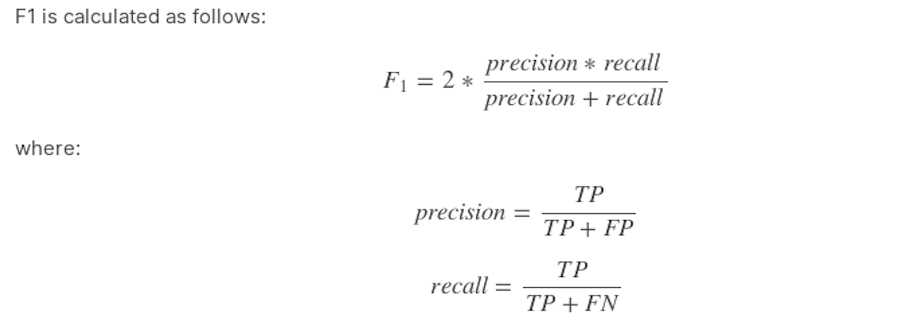

# 데이터
## 학습 데이터셋
* 구성
    * 아시안, 남녀, 20대 ~ 70대
* 통계
    * 전체 사람 명수: 4,500
    * 한 사람 당 사진 개수: 7
        * 마스크 착용 5장, 올바르게 착용하지 않은 경우 1장, 미착용 1장
    * 이미지 크기: (384, 512)
    * 전체 데이터셋의 60%가 학습 데이터셋으로 활용
* 클래스: 총 18개의 클래스

## 평가 데이터셋
* 나머지 40%개의 데이터셋 중
    * 20%: public 테스트셋
    * 20%: private 테스트셋
* 최종 순위는 private 테스트셋을 통해 산출한 점수로 확정

## 데이터 구조

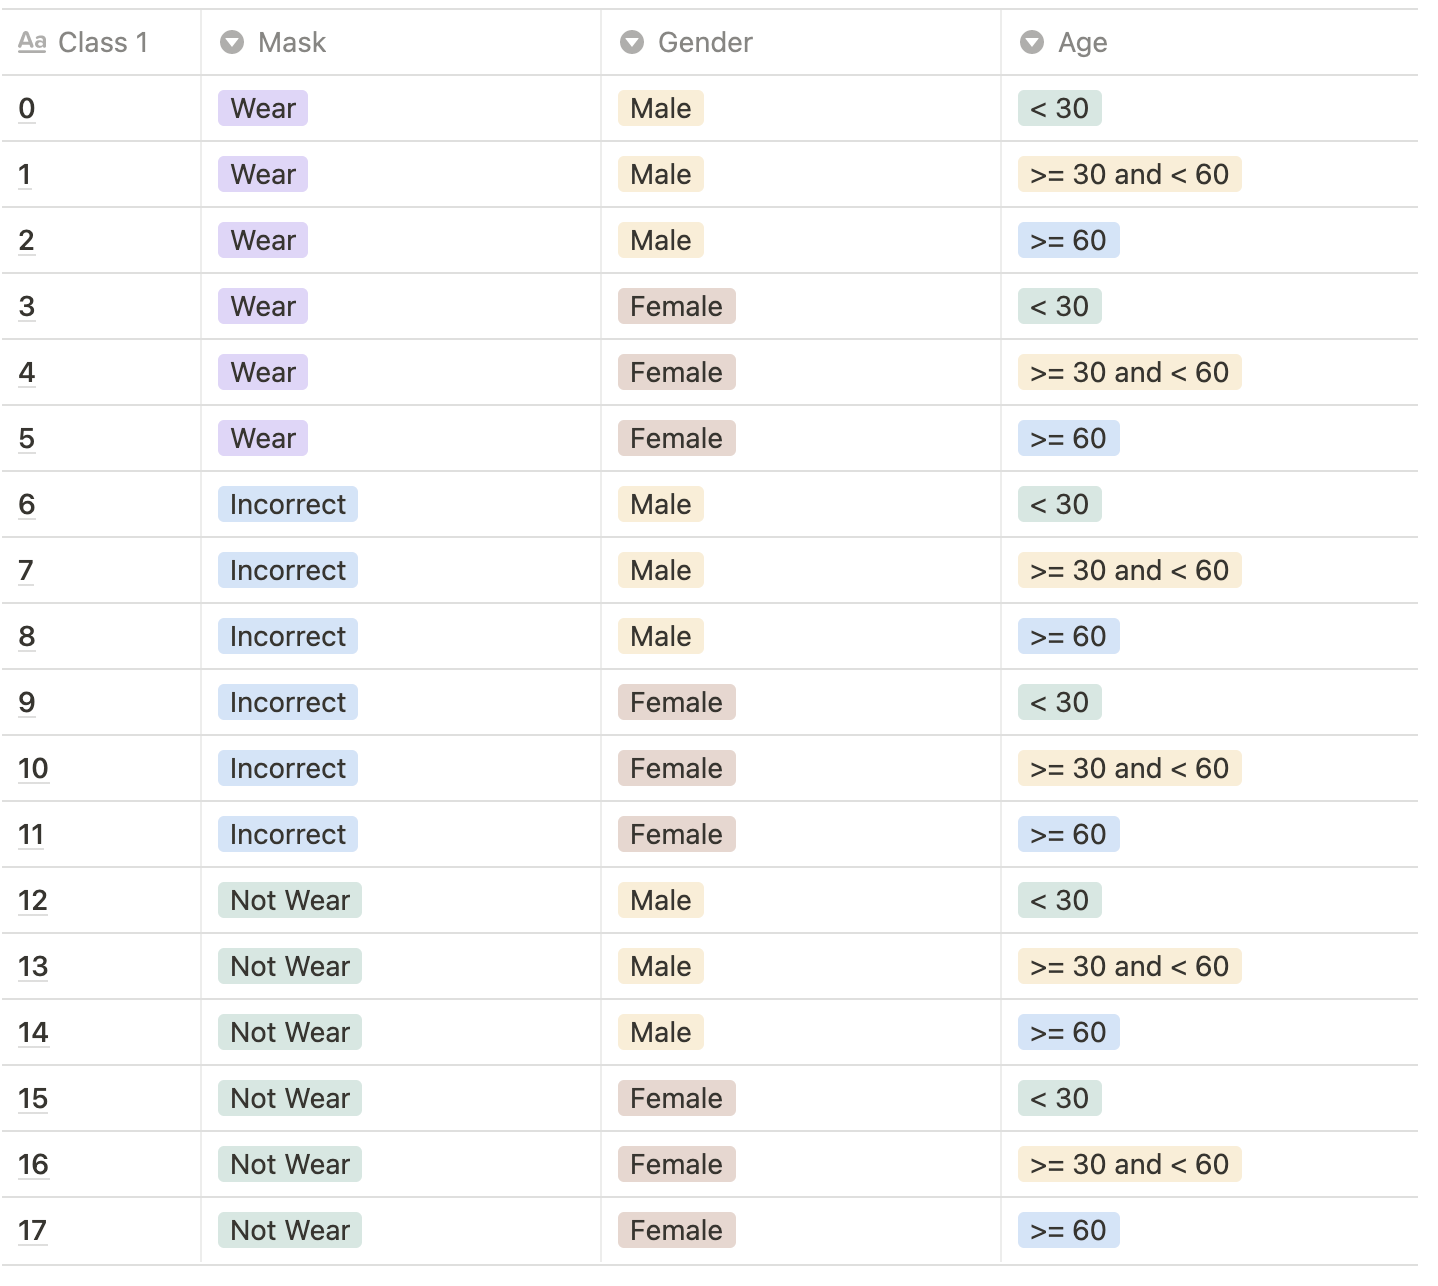

In [ ]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [ ]:
list_files('./data')

* mask1 ~ mask5: 마스크 착용
* normal: 마스크 미착용
* incorrect_mask: 마스크 올바르게 착용하지 않은 경우

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os, sys
import skimage.io
from skimage.transform import resize
#!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio
#!pip install --no-dependencies imgaug
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

## 사진 확인

In [ ]:
!pwd

In [ ]:
df_train = pd.read_csv('/opt/ml/input/data/train/train.csv')

In [ ]:
%%time
fig = plt.figure(figsize=(20, 100))

# display 10 images from each class
for i in range(1):
    row = df_train.loc[i]
    path=f"/opt/ml/input/data/train/images/{row['path']}"
    folders = sorted([f for f in os.listdir(path) if '._' not in f])
    
    for j, img in enumerate(folders):
        ax = fig.add_subplot(100, 7, i * 7 + j + 1, xticks=[], yticks=[])
        image = cv2.imread(path + "/" + img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('%s-%s' % (row['id'], img))
        

# 폴더로 구성되어 있는 이미지 한 폴더로 넣어주기
    * 003106_female_Asian_20+incorrect_mask.jpg
    * 003106_female_Asian_20+mask1.jpg
    * 003106_female_Asian_20+mask2.jpg
    * 003106_female_Asian_20+mask3.jpg
    * 003106_female_Asian_20+mask4.jpg
    * 003106_female_Asian_20+mask5.jpg
    * 003106_female_Asian_20+normal.jpg


In [ ]:
df_train.head()

In [ ]:
df_train_class = pd.DataFrame(columns = ['id', 'per_id', 'gender', 'age', 'mask', 'class', 'path'])
df_train_class.set_index('id', inplace=True)

In [ ]:
def return_class_simple(row, mask):
    # Assuming the mask is already labeled as 0,1,2
    # Each of them is 'wear', 'incorrect' and 'not wear'
    gender = 0 if row["gender"] == "male" else 3
    age = min(2, row["age"] // 30)

    # Print the class number
    return mask*6 + gender + age, age

In [ ]:
path = '../../input/data/train/images'

!rm -rf ./data/train/.DS_Store
!rm -rf ./data/train/images/.DS_Store
folders = sorted([f for f in os.listdir(path) if "._" not in f])

In [ ]:
idx = 0
mask_dict = {0: 'wear', 1: 'not wear', 2: 'incorrect'}
age_dict = {0: 'under 30', 1: '30 to 60', 2: 'over 60'}

for i in df_train.index:
    row = df_train.loc[i]
    imgs_path = os.path.join(path, row['path'])
    images = sorted([f for f in os.listdir(imgs_path) if "._" not in f])
    for img in images:
        #print(img)
        if img[:-4] == 'incorrect_mask':
            mask = 2 # incorrect
        elif img[:-4] == 'normal':
            mask = 1 # not wear
        else:
            mask = 0 # wear

        classnum, age = return_class_simple(row, mask)
        

        df_train_class.loc[idx] = [row['id'], row['gender'], age_dict[age], mask_dict[mask], classnum, os.path.join(imgs_path, img)]
        idx += 1


In [ ]:
df_train_class.head()

# 시각화
## 성별 - 마스크 착용

In [ ]:
group = df_train_class.groupby('gender')['mask'].value_counts().sort_index()
display(group)
print(df_train_class['gender'].value_counts())

In [ ]:
# 동시에 두 그래프를 그리는 경우 sharey를 하면 두 그래프의 y축 범주를 맞출 수 있다
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True) 
axes[0].bar(group['male'].index, group['male'], color='royalblue')
axes[1].bar(group['female'].index, group['female'], color='tomato')
plt.show()

## 나이 - 마스크 착용

In [ ]:
group = df_train_class.groupby('age')['mask'].value_counts().sort_index()
display(group)
print(df_train_class['age'].value_counts())

In [ ]:
# 동시에 두 그래프를 그리는 경우 sharey를 하면 두 그래프의 y축 범주를 맞출 수 있다
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True) 
axes[0].bar(group['under 30'].index, group['under 30'], color='royalblue')
axes[0].set_title('under 30', fontsize=20)

axes[1].bar(group['30 to 60'].index, group['30 to 60'], color='tomato')
axes[1].set_title('30 to 60', fontsize=20)

axes[2].bar(group['over 60'].index, group['over 60'], color='green')
axes[2].set_title('over 60', fontsize=20)


plt.show()

## 클래스 별
* '30 to 60'과 'over 60' 데이터가 많이 부족함

In [ ]:
sns.countplot(x='class',data=df_train_class,
             order=sorted(df_train_class['class'].unique())
             
             )

## 이미지 채널별 평ㄱㄴ

In [ ]:
!pwd

In [ ]:
%%time
fig = plt.figure(figsize=(20, 100))


r_mean = []
g_mean = []
b_mean = []

# display 10 images from each class
for i in range(len(df_train_class)):
    row = df_train_class.loc[i]

    image = cv2.imread(row['path'])
    #print(image.shape) # 이미지 크기

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    r = np.array(image)[:, :, 0]
    g = np.array(image)[:, :, 1]
    b = np.array(image)[:, :, 2]

    r_mean.append(np.mean(r))
    g_mean.append(np.mean(g))
    b_mean.append(np.mean(b))
        
  
        

In [ ]:
df_train_class

In [ ]:
df_train_class['r_mean'] = r_mean
df_train_class['g_mean'] = g_mean
df_train_class['b_mean'] = b_mean

In [ ]:
df_train_class = df_train_class.astype({'class':'float'})

In [ ]:
df_train_class.corr()

# Data Preprocessing & Dataloader

In [ ]:
train_df, valid_df = train_test_split(df_train_class, test_size=0.15, random_state=SEED)
print(train.shape, valid.shape)

In [ ]:
# 출처: https://github.com/utkuozbulak/pytorch-custom-dataset-examples/blob/master/src/custom_dataset_from_file.py
import numpy as np
from PIL import Image
import glob

import torch
from torch.utils.data.dataset import Dataset  # For custom datasets


class CustomDatasetFromFile(Dataset):
    def __init__(self, df_train, train=True):
        """
        A dataset example where the class is embedded in the file names
        This data example also does not use any torch transforms
        Args:
            folder_path (string): path to image folder
        """
        # Get image list
        self.image_list = df_train['path'].tolist()
        self.target = df_train['class'].tolist()
        # Calculate len
        self.data_len = len(self.image_list)

        self.train = train

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_path = self.image_list[index]
        # Open image
        # Open image
        im_as_im = Image.open(single_image_path)

        # Do some operations on image
        # Convert to numpy, dim = 28x28
        im_as_im = im_as_im.resize((28, 28))
        im_as_np = np.asarray(im_as_im)/255
        im_as_np = np.transpose(im_as_np, (2, 0, 1))

        # Transform image to tensor, change data type
        im_as_ten = torch.tensor(im_as_np)
        
        
        if self.train:
            label = (self.target[index])
            return (im_as_np, label)
        else:
            return im_as_np

    def __len__(self):
        return self.data_len

# Model

In [ ]:
import torch.nn as nn


class SimpleModel(nn.Module):
    def __init__(self):
        super(MnistCNNModel, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(2304, 18)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [ ]:
model

In [ ]:

   
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets



if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()])

    # Dataset variant 3:
    # Read images from a folder, image classes are embedded in file names
    # No csv is used whatsoever
    # No torch transformations are used
    # Preprocessing operations are defined inside the dataset
    custom_mnist_from_file = CustomDatasetFromFile(train_df)

    mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_file,
                                                    batch_size=10,
                                                    shuffle=False)

    model = SimpleModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(2): 
        for i, (images, labels) in enumerate(mn_dataset_loader):
            images = Variable(images)
            labels = Variable(labels)
            # Clear gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images.float())
            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()
            
            print('Epoch: %d Batch ID:%d Loss:%f' %(epoch, i, loss.data))
            

    print('A single forward-backward pass is done!')

# Predictions

In [ ]:
valid_dataset = CustomDatasetFromFile(valid_df)

valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                            batch_size=10,
                                            shuffle=False)

In [ ]:
targets = []
all_predictions = []
for images, labels in valid_dataloader:
    with torch.no_grad():
        #images = images.to(device)
        pred = model(images.float())
        pred = pred.argmax(dim=-1)
        targets.extend(labels.numpy())
        all_predictions.extend(pred.cpu().numpy())



In [ ]:
import sklearn.metrics as metrics

print('accuracy', metrics.accuracy_score(targets, all_predictions) )
print('f1', np.mean(metrics.f1_score(targets, all_predictions, average=None)))




In [ ]:
import pandas as pd

df = pd.read_csv("./special_mission/result.csv")

In [ ]:
df.head()

In [ ]:
df.drop(df['Unnamed:0'], axis=1)
df_train = df_train.drop(['age'], axis=1)